In [1]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline


[Learn the Basics](intro.html) ||
**Quickstart** ||
[Tensors](tensorqs_tutorial.html) ||
[Datasets & DataLoaders](data_tutorial.html) ||
[Transforms](transforms_tutorial.html) ||
[Build Model](buildmodel_tutorial.html) ||
[Autograd](autogradqs_tutorial.html) ||
[Optimization](optimization_tutorial.html) ||
[Save & Load Model](saveloadrun_tutorial.html)

# Quickstart
This section runs through the API for common tasks in machine learning. Refer to the links in each section to dive deeper.

## Working with data
PyTorch has two [primitives to work with data](https://pytorch.org/docs/stable/data.html):
``torch.utils.data.DataLoader`` and ``torch.utils.data.Dataset``.
``Dataset`` stores the samples and their corresponding labels, and ``DataLoader`` wraps an iterable around
the ``Dataset``.


In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

PyTorch offers domain-specific libraries such as [TorchText](https://pytorch.org/text/stable/index.html),
[TorchVision](https://pytorch.org/vision/stable/index.html), and [TorchAudio](https://pytorch.org/audio/stable/index.html),
all of which include datasets. For this tutorial, we  will be using a TorchVision dataset.

The ``torchvision.datasets`` module contains ``Dataset`` objects for many real-world vision data like
CIFAR, COCO ([full list here](https://pytorch.org/vision/stable/datasets.html)). In this tutorial, we
use the FashionMNIST dataset. Every TorchVision ``Dataset`` includes two arguments: ``transform`` and
``target_transform`` to modify the samples and labels respectively.



In [3]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

We pass the ``Dataset`` as an argument to ``DataLoader``. This wraps an iterable over our dataset, and supports
automatic batching, sampling, shuffling and multiprocess data loading. Here we define a batch size of 64, i.e. each element
in the dataloader iterable will return a batch of 64 features and labels.



In [4]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


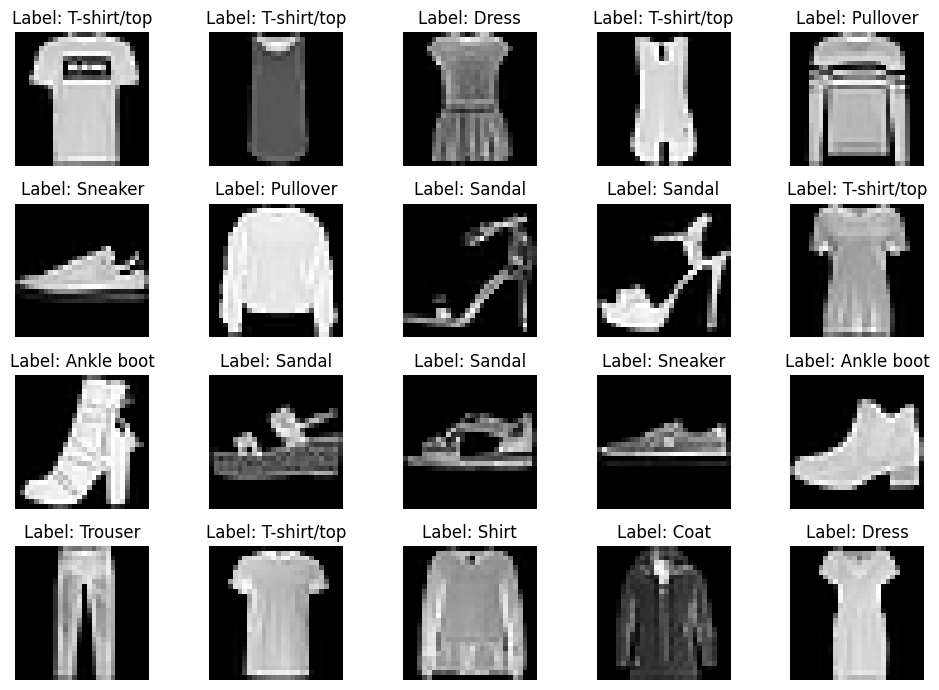

In [5]:
import matplotlib.pyplot as plt
import numpy as np
label_mapping = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}
image_data = train_dataloader.dataset.data[1:21]  # Get image data from index 1 to 20
label_data = train_dataloader.dataset.targets[1:21]  # Get label data from index 1 to 20

# Create a figure with a grid layout
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(10, 7))

# Iterate over the image and label data, and plot each image with its label in the grid
for idx, (image, label) in enumerate(zip(image_data, label_data)):
    ax = axes.flat[idx]
    ax.imshow(image, cmap='gray')  # Use 'gray' colormap for grayscale images
    ax.axis('off')
    ax.set_title(f"Label: {label_mapping[int(label)]}")

# Adjust the spacing between subplots
plt.tight_layout()
plt.show()



Read more about [loading data in PyTorch](data_tutorial.html).




--------------




## Creating Models
To define a neural network in PyTorch, we create a class that inherits
from [nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html). We define the layers of the network
in the ``__init__`` function and specify how data will pass through the network in the ``forward`` function. To accelerate
operations in the neural network, we move it to the GPU or MPS if available.



In [6]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc1 = nn.Linear(in_features=512, out_features=600)
        self.drop = nn.Dropout(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        
        return out

model = NeuralNetwork().to(device)
print(model)

Using cuda device
NeuralNetwork(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=512, out_features=600, bias=True)
  (drop): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_

Read more about [building neural networks in PyTorch](buildmodel_tutorial.html).




--------------




## Optimizing the Model Parameters
To train a model, we need a [loss function](https://pytorch.org/docs/stable/nn.html#loss-functions)
and an [optimizer](https://pytorch.org/docs/stable/optim.html).



In [13]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In a single training loop, the model makes predictions on the training dataset (fed to it in batches), and
backpropagates the prediction error to adjust the model's parameters.



In [14]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.cuda(), y.cuda()

        # Compute prediction error
        
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

We also check the model's performance against the test dataset to ensure it is learning.



In [15]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

The training process is conducted over several iterations (*epochs*). During each epoch, the model learns
parameters to make better predictions. We print the model's accuracy and loss at each epoch; we'd like to see the
accuracy increase and the loss decrease with every epoch.



In [24]:
epochs = 50
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.345218  [   64/60000]
loss: 2.366394  [ 6464/60000]
loss: 2.340000  [12864/60000]
loss: 2.341729  [19264/60000]
loss: 2.316428  [25664/60000]
loss: 2.301179  [32064/60000]
loss: 2.352201  [38464/60000]
loss: 2.340808  [44864/60000]
loss: 2.399106  [51264/60000]
loss: 2.361859  [57664/60000]
Test Error: 
 Accuracy: 5.6%, Avg loss: 2.340084 

Epoch 2
-------------------------------
loss: 2.351236  [   64/60000]
loss: 2.359265  [ 6464/60000]
loss: 2.359574  [12864/60000]
loss: 2.329961  [19264/60000]
loss: 2.326718  [25664/60000]
loss: 2.331188  [32064/60000]
loss: 2.346726  [38464/60000]
loss: 2.375491  [44864/60000]
loss: 2.396300  [51264/60000]
loss: 2.358796  [57664/60000]
Test Error: 
 Accuracy: 5.6%, Avg loss: 2.340084 

Epoch 3
-------------------------------
loss: 2.361236  [   64/60000]
loss: 2.369904  [ 6464/60000]
loss: 2.351475  [12864/60000]
loss: 2.352743  [19264/60000]
loss: 2.335924  [25664/60000]
loss: 2.314990  [32064/60000

loss: 2.383039  [ 6464/60000]
loss: 2.341603  [12864/60000]
loss: 2.360308  [19264/60000]
loss: 2.330974  [25664/60000]
loss: 2.340558  [32064/60000]
loss: 2.374875  [38464/60000]
loss: 2.352443  [44864/60000]
loss: 2.394793  [51264/60000]
loss: 2.389145  [57664/60000]
Test Error: 
 Accuracy: 5.6%, Avg loss: 2.340084 

Epoch 23
-------------------------------
loss: 2.354407  [   64/60000]
loss: 2.368977  [ 6464/60000]
loss: 2.347672  [12864/60000]
loss: 2.346797  [19264/60000]
loss: 2.337479  [25664/60000]
loss: 2.336099  [32064/60000]
loss: 2.350288  [38464/60000]
loss: 2.367999  [44864/60000]
loss: 2.403956  [51264/60000]
loss: 2.380773  [57664/60000]
Test Error: 
 Accuracy: 5.6%, Avg loss: 2.340084 

Epoch 24
-------------------------------
loss: 2.353238  [   64/60000]
loss: 2.380944  [ 6464/60000]
loss: 2.366020  [12864/60000]
loss: 2.328525  [19264/60000]
loss: 2.308195  [25664/60000]
loss: 2.317973  [32064/60000]
loss: 2.340137  [38464/60000]
loss: 2.354115  [44864/60000]
loss: 

loss: 2.378023  [ 6464/60000]
loss: 2.363989  [12864/60000]
loss: 2.306315  [19264/60000]
loss: 2.300907  [25664/60000]
loss: 2.303270  [32064/60000]
loss: 2.362034  [38464/60000]
loss: 2.344142  [44864/60000]
loss: 2.402997  [51264/60000]
loss: 2.368112  [57664/60000]
Test Error: 
 Accuracy: 5.6%, Avg loss: 2.340084 

Epoch 44
-------------------------------
loss: 2.381206  [   64/60000]
loss: 2.367489  [ 6464/60000]
loss: 2.334162  [12864/60000]
loss: 2.320570  [19264/60000]
loss: 2.318718  [25664/60000]
loss: 2.297235  [32064/60000]
loss: 2.374539  [38464/60000]
loss: 2.340362  [44864/60000]
loss: 2.405297  [51264/60000]
loss: 2.374254  [57664/60000]
Test Error: 
 Accuracy: 5.6%, Avg loss: 2.340084 

Epoch 45
-------------------------------
loss: 2.349159  [   64/60000]
loss: 2.374391  [ 6464/60000]
loss: 2.362109  [12864/60000]
loss: 2.330894  [19264/60000]
loss: 2.342329  [25664/60000]
loss: 2.328612  [32064/60000]
loss: 2.378128  [38464/60000]
loss: 2.355203  [44864/60000]
loss: 

Read more about [Training your model](optimization_tutorial.html).




--------------




## Saving Models
A common way to save a model is to serialize the internal state dictionary (containing the model parameters).



In [14]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


## Loading Models

The process for loading a model includes re-creating the model structure and loading
the state dictionary into it.



In [15]:
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

This model can now be used to make predictions.



torch.Size([1, 1, 28, 28])


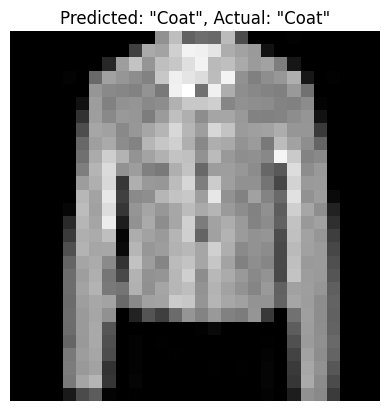

In [18]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]
model.eval()
x, y = test_data[10][0], test_data[10][1]
with torch.no_grad():
    x = x.to(device)
    x = x.unsqueeze(0) 
    print(x.shape)
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]

# Convert the image tensor to a NumPy array
image_array = x.cpu().numpy().squeeze()

# Plot the image using Matplotlib
plt.imshow(image_array, cmap='gray')  # Use 'gray' colormap for grayscale images
plt.axis('off')
plt.title(f'Predicted: "{predicted}", Actual: "{actual}"')
plt.show()

Read more about [Saving & Loading your model](saveloadrun_tutorial.html).


